In [31]:
import pandas as pd
import numpy as np
import joblib as jb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import shap
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import cv2
import colorsys
shap.initjs()

In [7]:
path = 'generated/dataframes/dataset_dataframe.pkl.z'

In [8]:
df = jb.load(path)
df.head()

,x,y,z,b1,b2,b3,b4,b5,b6,b7,b8,cspmb7
0,233,1130,3.195862,0.1199,0.0866,0.0667,0.0464,0.0490,0.0316,0.0283,0.0238,23.382784
1,233,1131,3.273030,0.1199,0.0880,0.0668,0.0457,0.0490,0.0316,0.0283,0.0237,23.382784
2,233,1132,3.299687,0.1199,0.0879,0.0666,0.0461,0.0488,0.0324,0.0281,0.0238,23.158824
3,233,1133,3.268182,0.1199,0.0882,0.0692,0.0452,0.0488,0.0324,0.0281,0.0232,23.158824
4,233,1134,3.278125,0.1196,0.0884,0.0677,0.0454,0.0489,0.0323,0.0285,0.0238,23.607309


# Bands b1 b5 b6 cspmb7

In [10]:
bands_cspm_features = df[['b1', 'b5', 'b6', 'cspmb7']]
bands_cspm_target = df.z

X_train, X_val, y_train, y_val = train_test_split(bands_cspm_features, bands_cspm_target, test_size=0.3, random_state=42,shuffle=True)

In [112]:
th = 600
X_train = df[df.y >= th][['b1', 'b5', 'b6', 'cspmb7']]
X_val = df[df.y < th][['b1', 'b5', 'b6', 'cspmb7']]
y_train = df[df.y >= th]['z']
y_val = df[df.y < th]['z']

In [113]:
print(X_train.shape,X_val.shape)

(9368, 4) (8907, 4)


In [11]:
rf_bands_cspm_baseline = RandomForestRegressor()
#lgbm_bands_cspm_baseline = LGBMRegressor()

rf_bands_cspm_baseline.fit(X_train, y_train)
#lgbm_bands_cspm_baseline.fit(X_train, y_train)

RandomForestRegressor()

In [12]:
pred_rf_bands_cspm_baseline = rf_bands_cspm_baseline.predict(X_val)
#pred_lgbm_bands_cspm_baseline = lgbm_bands_cspm_baseline.predict(X_val)

In [77]:
print('RF Bands and CSPM Metrics:')
print('R2 score:', r2_score(y_val, pred_rf_bands_cspm_baseline))
print('MAE:', mean_absolute_error(y_val, pred_rf_bands_cspm_baseline))
print('MSE:', mean_squared_error(y_val, pred_rf_bands_cspm_baseline))
print('RMSE:', np.sqrt(mean_squared_error(y_val, pred_rf_bands_cspm_baseline)))
print('Bias:', pred_rf_bands_cspm_baseline.mean() - y_val.mean())


#print('LGBM Bands and CSPM Metrics:')
#print('R2 score:', r2_score(y_val, pred_lgbm_bands_cspm_baseline))
#print('MAE:', r2_score(y_val, pred_lgbm_bands_cspm_baseline))
#print('MSE:', mean_absolute_error(y_val, pred_lgbm_bands_cspm_baseline))
#print('RMSE:', np.sqrt(mean_squared_error(y_val, pred_lgbm_bands_cspm_baseline)))

RF Bands and CSPM Metrics:
R2 score: 0.8559861899018081
MAE: 0.9906883370240824
MSE: 2.905335584690429
RMSE: 1.704504498289878
Bias: 0.05599262024911145


In [14]:
explainer = shap.TreeExplainer(rf_bands_cspm_baseline)
shap_values = explainer.shap_values(X_train, approximate=True)

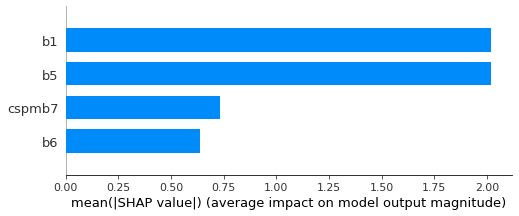

In [15]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [16]:
pred_bands_cspm_df = pd.DataFrame(index=X_val.index)
pred_bands_cspm_df['rf_pred'] = pred_rf_bands_cspm_baseline
#pred_bands_cspm_df['lgbm_pred'] = pred_lgbm_bands_cspm_baseline

In [19]:
train_data = pd.concat([X_train, y_train, df[df.index.isin(X_train.index)][['x','y', 'z']]], axis=1)
val_data = pd.concat([X_val, y_val, df[df.index.isin(X_val.index)][['x','y']], pred_bands_cspm_df], axis=1)

In [18]:
pred_bands_cspm_df

,rf_pred
16174,6.853628
6425,7.855518
14992,12.116461
7712,4.558289
1042,3.846814
...,...
6447,8.836774
878,4.924640
3398,2.549510
4361,2.099618


(array([   5.,   22.,   62.,  376., 4124.,  734.,  125.,   18.,    9.,
           8.]),
 array([-12.10808658,  -9.52745748,  -6.94682839,  -4.36619929,
         -1.7855702 ,   0.7950589 ,   3.37568799,   5.95631709,
          8.53694618,  11.11757528,  13.69820437]),
 <BarContainer object of 10 artists>)

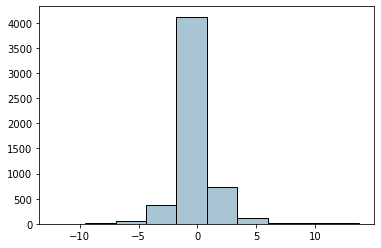

In [24]:
plt.hist(val_data['z']-val_data['rf_pred'], bins=10, color='#A9C5D3', edgecolor='black')

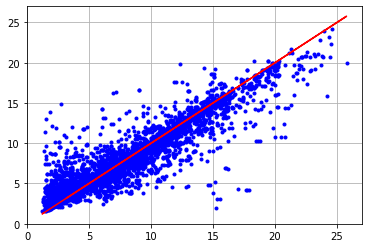

In [23]:
plt.grid()
plt.plot(val_data['z'],val_data['rf_pred'],'b.',val_data['z'],val_data['z'],'r')

In [71]:
blank = np.ones((val_data.y.max(),val_data.x.max(),3))*255
print(blank.shape)

(1638, 2295, 3)


In [72]:
for i, row in enumerate(val_data.itertuples()):
    x = int(row.x)
    y = int(row.y)
    residual = row.z - row.rf_pred
    color = [int(e*255) for e in (colorsys.hls_to_rgb((10-residual)*236/(20*360), 0.5, 1))]
    blank = cv2.circle(blank,(x,y),10,color,10)
    #abs_error_image[y][x] = [int(e*255) for e in (colorsys.hls_to_rgb(abs_error/(df_data['abs_error'].max()*1.2), 0.5, 1))]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True

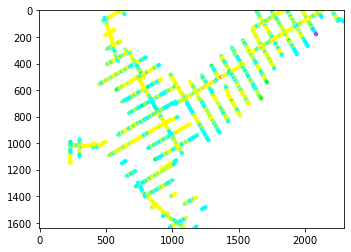

In [76]:
plt.imshow(blank)
cv2.imwrite('residual.jpg',blank)

In [132]:
jb.dump(rf_bands_cspm_baseline, 'generated/models/model_rf.pkl.z')
#jb.dump(lgbm_bands_cspm_baseline, 'generated/dataframes/model_lgbm_bands_cspm_baseline_low_var_filter.pkl.z')

['generated/models/model_rf.pkl.z']

In [133]:
jb.dump(train_data, 'generated/dataframes/train_data.pkl.z')
jb.dump(val_data, 'generated/dataframes/test_data.pkl.z')

['generated/dataframes/test_data.pkl.z']

In [134]:
jb.dump(pred_rf_bands_cspm_baseline, 'generated/dataframes/rf_bat_prediction.pkl.z')
#jb.dump(pred_lgbm_bands_cspm_baseline, '../data/generated_baseline/bands_cspm/pred_lgbm_bands_cspm_baseline_low_var_filter.pkl.z')

['generated/dataframes/rf_bat_prediction.pkl.z']